## Running a SliM3 Simulation with `shadie`

In [5]:
from shadie import Shadie

In [6]:
empty = Shadie()

06:44 | WARNING | __init__        | if no tree is provided, 'generations'argument must be provided (defines length of simulation in generations. Default value = 10000
06:44 | INFO    | __init__        | testing part of code: p0


In [7]:
empty.chromosome
empty.demog

gen src    Ne
0   1  p1  1000

In [8]:
empty.write()

In [9]:
##run function
empty.run()

CalledProcessError: Command '['slim', '-m', '-s', '0', 'shadie.slim']' returned non-zero exit status 1.

In [6]:
empty.postsim()

ancestral	derived	count
A	A	1
A	C	23
A	G	33
A	T	26
C	A	26
C	C	5
C	G	31
C	T	29
G	A	31
G	C	25
G	G	10
G	T	27
T	A	29
T	C	29
T	G	24
T	T	5


In [ ]:
svg = empty.ts.draw_svg()
svg

In [50]:
from IPython.display import SVG, display
display(SVG(svg()))

# pyslim

In [11]:
import pyslim
import msprime

orig_ts = pyslim.load("shadie.trees")
alive = orig_ts.individuals_alive_at(0)

print(f"There are {len(alive)} individuals alive from the final generation.")

There are 1000 individuals alive from the final generation.


In [10]:
print(empty.ts.individual(1))

AttributeError: 'Shadie' object has no attribute 'ts'

In [4]:
empty.ts.population

AttributeError: 'Shadie' object has no attribute 'ts'

### Adding neutral mutations to a SLiM simulation

If you have recorded a tree sequence in SLiM, likely you have not included any neutral mutations, since it is much more efficient to simply add these on afterwards. To add these (in a completely equivalent way to having included them during the simulation), you can use the `msprime.mutate()` function, which returns a new tree sequence with additional mutations.

In [17]:
ts = pyslim.SlimTreeSequence(msprime.mutate(orig_ts, rate=1e-6, keep=True))

print(f"The tree sequence now has {ts.num_mutations} mutations, "
      f"and mean pairwise nucleotide diversity is {ts.diversity()}.")

The tree sequence now has 673 mutations, and mean pairwise nucleotide diversity is 0.006044976063031551.


/Users/elissa/miniconda3/lib/python3.8/site-packages/pyslim/slim_tree_sequence.py:895: UserWarning: This is an version 0.5 SLiM tree sequence. When you write this out, it will be converted to version 0.6.
  warnings.warn("This is an version {} SLiM tree sequence.".format(file_version) +


### LD Calculator

In [38]:
ld_calc = tskit.LdCalculator(ts)

In [18]:
import tskit
import matplotlib.pyplot as pyplot

ld_calc = tskit.LdCalculator(ts)
A = ld_calc.r2_matrix()

# Now plot this matrix.
x = A.shape[0] / pyplot.rcParams["figure.dpi"]
x = max(x, pyplot.rcParams["figure.figsize"][0])
fig, ax = pyplot.subplots(figsize=(x, x))
fig.tight_layout(pad=0)
im = ax.imshow(A, interpolation="none", vmin=0, vmax=1, cmap="Blues")
ax.set_xticks([])
ax.set_yticks([])
for s in "top", "bottom", "left", "right":
    ax.spines[s].set_visible(False)
pyplot.gcf().colorbar(im, shrink=0.5, pad=0)
pyplot.savefig("ld.svg")  

LibraryError: Only infinite sites mutations are supported for this operation

In [32]:
# the code for r2_matrix
class LdCalculator:
    """
    Class for calculating `linkage disequilibrium
    <https://en.wikipedia.org/wiki/Linkage_disequilibrium>`_ coefficients
    between pairs of mutations in a :class:`TreeSequence`. This class requires
    the `numpy <http://www.numpy.org/>`_ library.

    This class supports multithreaded access using the Python :mod:`threading`
    module. Separate instances of :class:`LdCalculator` referencing the
    same tree sequence can operate in parallel in multiple threads.

    .. note:: This class does not currently support sites that have more than one
        mutation. Using it on such a tree sequence will raise a LibraryError with
        an "Unsupported operation" message.

    :param TreeSequence tree_sequence: The tree sequence containing the
        mutations we are interested in.
    """

    def get_r2(self, a, b):
        # Deprecated alias for r2(a, b)
        return self.r2(a, b)

    def r2(self, a, b):
        """
        Returns the value of the :math:`r^2` statistic between the pair of
        mutations at the specified indexes. This method is *not* an efficient
        method for computing large numbers of pairwise; please use either
        :meth:`.r2_array` or :meth:`.r2_matrix` for this purpose.

        :param int a: The index of the first mutation.
        :param int b: The index of the second mutation.
        :return: The value of :math:`r^2` between the mutations at indexes
            ``a`` and ``b``.
        :rtype: float
        """
        with self._instance_lock:
            return self._ll_ld_calculator.get_r2(a, b)


    def get_r2_array(self, a, direction=1, max_mutations=None, max_distance=None):
        # Deprecated alias for r2_array
        return self.r2_array(a, direction, max_mutations, max_distance)

    def r2_array(self, a, direction=1, max_mutations=None, max_distance=None):
        """
        Returns the value of the :math:`r^2` statistic between the focal
        mutation at index :math:`a` and a set of other mutations. The method
        operates by starting at the focal mutation and iterating over adjacent
        mutations (in either the forward or backwards direction) until either a
        maximum number of other mutations have been considered (using the
        ``max_mutations`` parameter), a maximum distance in sequence
        coordinates has been reached (using the ``max_distance`` parameter) or
        the start/end of the sequence has been reached. For every mutation
        :math:`b` considered, we then insert the value of :math:`r^2` between
        :math:`a` and :math:`b` at the corresponding index in an array, and
        return the entire array. If the returned array is :math:`x` and
        ``direction`` is :data:`tskit.FORWARD` then :math:`x[0]` is the
        value of the statistic for :math:`a` and :math:`a + 1`, :math:`x[1]`
        the value for :math:`a` and :math:`a + 2`, etc. Similarly, if
        ``direction`` is :data:`tskit.REVERSE` then :math:`x[0]` is the
        value of the statistic for :math:`a` and :math:`a - 1`, :math:`x[1]`
        the value for :math:`a` and :math:`a - 2`, etc.

        :param int a: The index of the focal mutation.
        :param int direction: The direction in which to travel when
            examining other mutations. Must be either
            :data:`tskit.FORWARD` or :data:`tskit.REVERSE`. Defaults
            to :data:`tskit.FORWARD`.
        :param int max_mutations: The maximum number of mutations to return
            :math:`r^2` values for. Defaults to as many mutations as
            possible.
        :param float max_distance: The maximum absolute distance between
            the focal mutation and those for which :math:`r^2` values
            are returned.
        :return: An array of double precision floating point values
            representing the :math:`r^2` values for mutations in the
            specified direction.
        :rtype: numpy.ndarray
        :warning: For efficiency reasons, the underlying memory used to
            store the returned array is shared between calls. Therefore,
            if you wish to store the results of a single call to
            ``get_r2_array()`` for later processing you **must** take a
            copy of the array!
        """
        if max_mutations is None:
            max_mutations = -1
        if max_distance is None:
            max_distance = sys.float_info.max
        item_size = struct.calcsize("d")
        buffer = bytearray(self._tree_sequence.get_num_mutations() * item_size)
        with self._instance_lock:
            num_values = self._ll_ld_calculator.get_r2_array(
                buffer,
                a,
                direction=direction,
                max_mutations=max_mutations,
                max_distance=max_distance,
            )
        return np.frombuffer(buffer, "d", num_values)


    def get_r2_matrix(self):
        # Deprecated alias for r2_matrix
        return self.r2_matrix()

    def r2_matrix(self):
        """
        Returns the complete :math:`m \\times m` matrix of pairwise
        :math:`r^2` values in a tree sequence with :math:`m` mutations.

        :return: An 2 dimensional square array of double precision
            floating point values representing the :math:`r^2` values for
            all pairs of mutations.
        :rtype: numpy.ndarray
        """
        m = self._tree_sequence.get_num_mutations()
        A = np.ones((m, m), dtype=float)
        for j in range(m - 1):
            a = self.get_r2_array(j)
            A[j, j + 1 :] = a
            A[j + 1 :, j] = a
        return A

In [36]:
import numpy as np

m = empty.ts.get_num_mutations()
A = np.ones((m, m), dtype=float)


354

In [43]:
ld_calc.get_r2_matrix()

LibraryError: Only infinite sites mutations are supported for this operation

## tskit Stuff

Moving along tree sequence:

In [9]:
print("Tree sequence has {} trees".format(empty.ts.num_trees))
print()
for tree in empty.ts.trees():
    print(
        "Tree {} covers [{:.2f}, {:.2f}); TMRCA = {:.4f}".format(
            tree.index, *tree.interval, tree.time(tree.root)
        )
    )

Tree sequence has 5 trees

Tree 0 covers [0.00, 7281.00); TMRCA = 3000.0000
Tree 1 covers [7281.00, 13609.00); TMRCA = 3000.0000
Tree 2 covers [13609.00, 15288.00); TMRCA = 3000.0000
Tree 3 covers [15288.00, 16381.00); TMRCA = 3000.0000
Tree 4 covers [16381.00, 20000.00); TMRCA = 3000.0000


In [16]:
#calculate diversity
x = empty.ts.diversity()
print("Average diversity per unit sequence length = {:.3G}".format(x))

Average diversity per unit sequence length = 0.00358


In [20]:
import numpy as np

#diversity along windows
windows = np.linspace(0, empty.ts.sequence_length, num=5)
x = empty.ts.diversity(windows=windows)
print(windows)
print(x)

[    0.  5000. 10000. 15000. 20000.]
[0.00302701 0.00349368 0.00466033 0.00312456]


Many population genetic statistics compare multiple sets of samples to each other. For example, the `TreeSequence.divergence()` method computes the divergence between two subsets of samples:

In [21]:
A = empty.ts.samples()[:100]
B = empty.ts.samples()[:100]
x = empty.ts.divergence([A, B])
print(x)

0.0035004000000000046


In [23]:
#you can use the windows to get divergence between two samples for different windows:
x = empty.ts.divergence([A, B], windows=windows)
print(x)

[0.00296684 0.0034114  0.00458756 0.0030358 ]


<bound method TreeSequence.samples of <pyslim.slim_tree_sequence.SlimTreeSequence object at 0x7fa37e733490>>

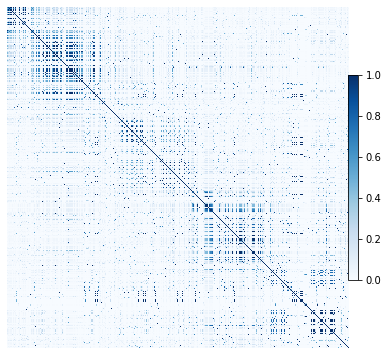

In [14]:
#example of ld

import msprime
import tskit
import matplotlib.pyplot as pyplot

ts = msprime.simulate(100, recombination_rate=10, mutation_rate=20, random_seed=1)
ld_calc = tskit.LdCalculator(ts)
A = ld_calc.r2_matrix()

# Now plot this matrix.
x = A.shape[0] / pyplot.rcParams["figure.dpi"]
x = max(x, pyplot.rcParams["figure.figsize"][0])
fig, ax = pyplot.subplots(figsize=(x, x))
fig.tight_layout(pad=0)
im = ax.imshow(A, interpolation="none", vmin=0, vmax=1, cmap="Blues")
ax.set_xticks([])
ax.set_yticks([])
for s in "top", "bottom", "left", "right":
    ax.spines[s].set_visible(False)
pyplot.gcf().colorbar(im, shrink=0.5, pad=0)
pyplot.savefig("ld.svg")  

In [15]:
ld_calc = tskit.LdCalculator(empty.ts)
A = ld_calc.r2_matrix()

# Now plot this matrix.
x = A.shape[0] / pyplot.rcParams["figure.dpi"]
x = max(x, pyplot.rcParams["figure.figsize"][0])
fig, ax = pyplot.subplots(figsize=(x, x))
fig.tight_layout(pad=0)
im = ax.imshow(A, interpolation="none", vmin=0, vmax=1, cmap="Blues")
ax.set_xticks([])
ax.set_yticks([])
for s in "top", "bottom", "left", "right":
    ax.spines[s].set_visible(False)
pyplot.gcf().colorbar(im, shrink=0.5, pad=0)
pyplot.savefig("ld.svg")  

LibraryError: Only infinite sites mutations are supported for this operation

In [31]:
maxp = "p50"
maxp[:-1]

'p5'

In [24]:
zeroes = []
one = [1]
for i in maxp:
    zeroes.append(0)
n = one + zeroes 
prefix = (''.join([str(a) for a in n]))
"p" + prefix + population[1]

population = "p1"

'p1001'